# 📊 Evaluation Pipeline: DWF RL Model
This notebook evaluates the trained RL model’s performance using core metrics like cancellation rate, rider wait time, and profit impact.

In [85]:
# Load Libraries
import gymnasium as gym
from gymnasium import Env, spaces
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from tensorboard.backend.event_processing import event_accumulator

Environment Loading

In [86]:
class RideHailingEnv_DWF(Env):
    def __init__(self, df):
        super(RideHailingEnv_DWF, self).__init__()
        self.df = df.reset_index(drop=True)
        self.current_idx = 0
        self.episode_limit = 1000
        self.episode_start = 0

        self.observation_space = spaces.Box(low=0, high=1, shape=(8,), dtype=np.float32)
        self.action_space = spaces.Box(
            low=np.array([-0.15, 0.0]),
            high=np.array([0.15, 5.0]),
            dtype=np.float32
        )

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.current_idx = np.random.randint(0, len(self.df) - self.episode_limit)
        self.episode_start = self.current_idx
        return self._get_observation(), {}

    def step(self, action):
        if self.current_idx >= len(self.df) - 1 or (self.current_idx - self.episode_start >= self.episode_limit):
            obs = self._get_observation()
            done = True
            reward = 0.0
            self.episode_start = self.current_idx + 1
            return obs, reward, done, False, {"CR": 0.5}

        row = self.df.iloc[self.current_idx]
        fare_adjustment, rider_incentive = np.round(action, 2)
        t_i = row['Request to Pickup']
        base_fare = row.get('Base Fare', 10.0)
        delta = 0.2 * base_fare

        # --- Behavior-based features
        rank_percentile = (self.df['Request to Pickup'] < t_i).sum() / len(self.df)
        epsilon = np.random.normal(loc=0.0, scale=0.02)
        RPI = np.clip(1.0 - rank_percentile + epsilon, 0.0, 1.0)

        # Amplify the impact of actions using exponential DPI
        action_signal = rider_incentive + abs(fare_adjustment * base_fare)
        DPI = np.clip(1.0 - np.exp(-0.6 * action_signal) + epsilon, 0.0, 1.0)

        # CR: stronger dependency on DPI (action-driven cancellation)
        cr_input = 1.2 * rank_percentile - 1.3 * RPI - 2.0 * DPI
        CR = 1.0 / (1.0 + np.exp(-cr_input))
        ride_completed = CR < 0.5

        # === Reward Components
        base_reward = 1.5 * (1.0 - CR)             # Completion-focused reward

        cost = rider_incentive + abs(fare_adjustment) * delta
        cost_ratio = cost / (base_fare + 5)
        cost_penalty = 0.5 * max(cost_ratio - 0.2, 0.0)  # Penalty only after 20%

        efficiency_bonus = 0.2 if ride_completed and cost_ratio < 0.2 else 0.0

        reward = base_reward - cost_penalty + efficiency_bonus
        reward = np.clip(reward, -2.0, 2.0)

        self.current_idx += 1
        done = False
        obs = self._get_observation()

        return obs, reward, done, False, {
            "CR": CR,
            "RPI": RPI,
            "DPI": DPI,
            "cost": cost,
            "base_reward": base_reward,
            "cost_penalty": cost_penalty
        }
    
    def _get_observation(self):
        if self.current_idx >= len(self.df):
            return np.zeros(self.observation_space.shape, dtype=np.float32)
        row = self.df.iloc[self.current_idx]
        return np.array([
            row['Pickup Location'],
            row['Request to Pickup'],
            row['Time of Day'],
            row['Month of Year'],
            row['RPI'],
            row['DPI'],
            row['CR'],
            row['Historical Demand Forecast']
        ], dtype=np.float32)


Model Perfoemance Metrics

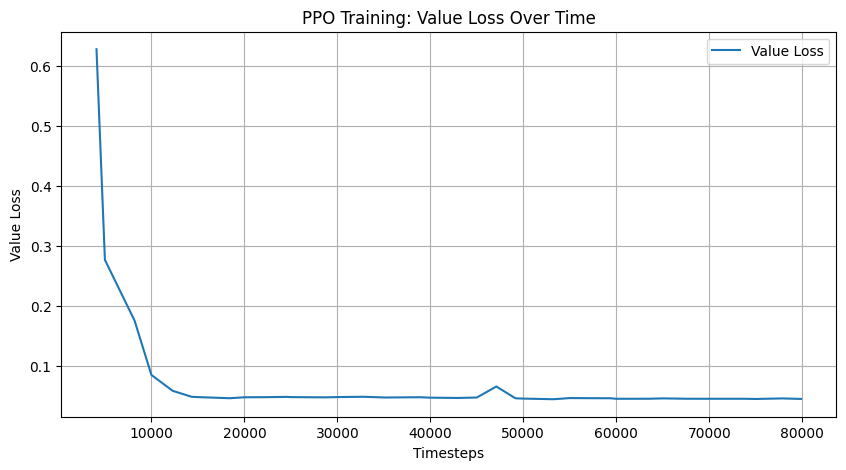

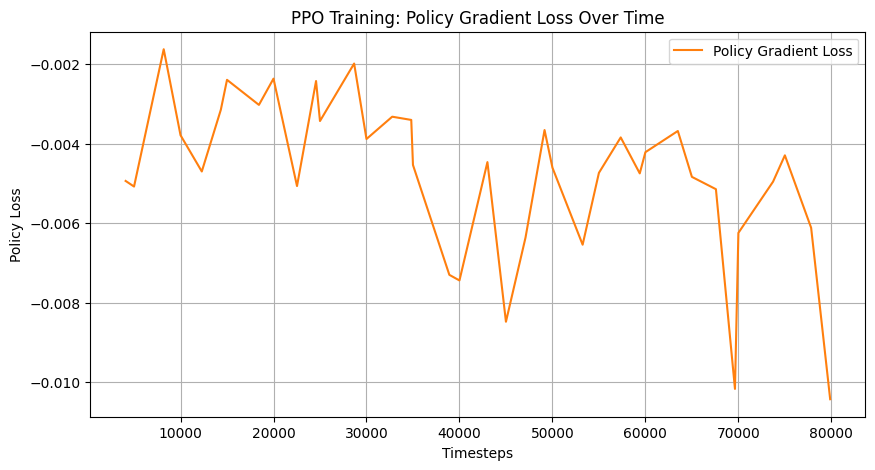

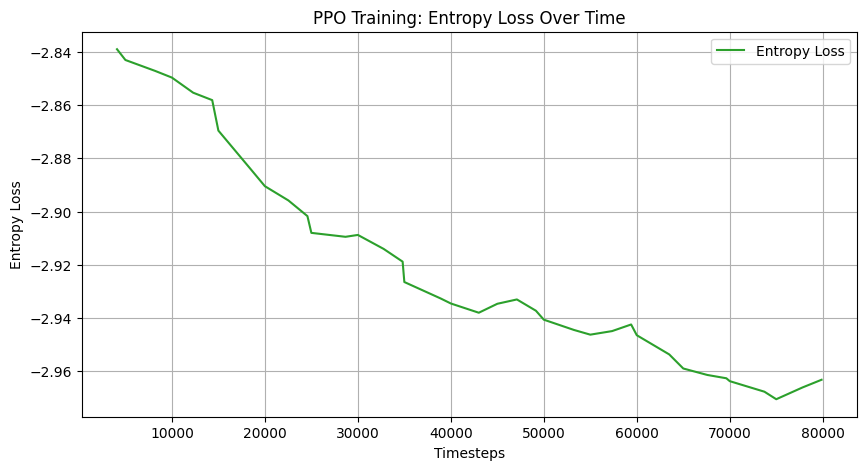

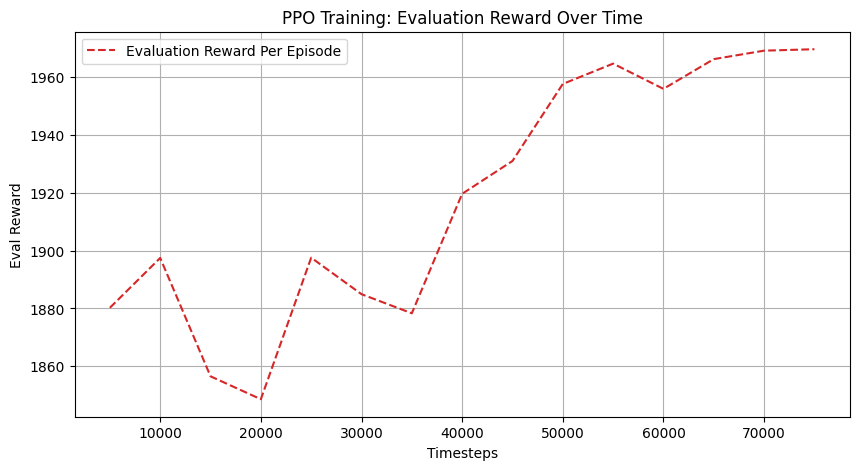

In [ ]:
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

# Load logs
ea = event_accumulator.EventAccumulator('ppo_tensorboard_logs/DWF/PPO_1')
ea.Reload()

# Extract scalars
val_loss = ea.Scalars('train/value_loss')
pol_loss = ea.Scalars('train/policy_gradient_loss')
entropy  = ea.Scalars('train/entropy_loss')
eval_rew = ea.Scalars('eval/mean_reward')

# Convert to lists
val_steps, val_vals = zip(*[(x.step, x.value) for x in val_loss])
pol_steps, pol_vals = zip(*[(x.step, x.value) for x in pol_loss])
ent_steps, ent_vals = zip(*[(x.step, x.value) for x in entropy])
eval_steps, eval_vals = zip(*[(x.step, x.value) for x in eval_rew])

# === Plot 1: Value Loss ===
plt.figure(figsize=(10, 5))
plt.plot(val_steps, val_vals, label="Value Loss", color='tab:blue')
plt.xlabel("Timesteps")
plt.ylabel("Value Loss")
plt.title("PPO Training: Value Loss Over Time")
plt.grid(True)
plt.legend()
plt.show()

# === Plot 2: Policy Gradient Loss ===
plt.figure(figsize=(10, 5))
plt.plot(pol_steps, pol_vals, label="Policy Gradient Loss", color='tab:orange')
plt.xlabel("Timesteps")
plt.ylabel("Policy Loss")
plt.title("PPO Training: Policy Gradient Loss Over Time")
plt.grid(True)
plt.legend()
plt.show()

# === Plot 3: Entropy Loss ===
plt.figure(figsize=(10, 5))
plt.plot(ent_steps, ent_vals, label="Entropy Loss", color='tab:green')
plt.xlabel("Timesteps")
plt.ylabel("Entropy Loss")
plt.title("PPO Training: Entropy Loss Over Time")
plt.grid(True)
plt.legend()
plt.show()

# === Plot 4: Evaluation Reward ===
plt.figure(figsize=(10, 5))
plt.plot(eval_steps, eval_vals, label="Evaluation Reward Per Episode", color='tab:red', linestyle='--')
plt.xlabel("Timesteps")
plt.ylabel("Eval Reward")
plt.title("PPO Training: Evaluation Reward Over Time")
plt.grid(True)
plt.legend()
plt.show()


Framework Evaluation

In [88]:
#test_model = PPO.load("models/dwf_model")
test_df = pd.read_csv("datasets/test_split.csv")

In [89]:
def evaluate_model_on_test(model: PPO, test_df: pd.DataFrame):

    print(f"Model Name: {model}")

    env = RideHailingEnv_DWF(test_df.copy())  # use a copy to avoid modifying original
    obs, _ = env.reset()
    
    done = False
    total_cost = 0
    retained_from_cancel = 0
    completed_rides = 0
    original_cancellations = 0
    ride_count = 0
    incentive_total = 0
    fare_adj_total = 0

    while not done:
        row = env.df.iloc[env.current_idx]
        base_fare = row['Base Fare']
        t_i = row['Request to Pickup']
        original_cr = row['CR']  # original cancellation rate before action

        # Count originally cancelled rides
        originally_cancelled = original_cr >= 0.5
        if originally_cancelled:
            original_cancellations += 1

        # Predict action
        action, _ = model.predict(obs, deterministic=True)
        fare_adj = np.clip(action[0], -0.15, 0.15)
        incentive = np.clip(action[1], 0.0, 5.0)

        obs, reward, done, _, info = env.step(action)
        updated_cr = info["CR"]

        # Track completion & intervention success
        ride_completed = updated_cr < 0.5
        if ride_completed:
            completed_rides += 1
        if originally_cancelled and ride_completed:
            retained_from_cancel += 1

        # Track costs
        delta = 0.2 * base_fare
        cost = incentive + abs(fare_adj) * delta
        total_cost += cost
        incentive_total += incentive
        fare_adj_total += abs(fare_adj)
        ride_count += 1

    # Metrics
    avg_cancel_rate = 1 - (completed_rides / ride_count)
    avg_incentive = incentive_total / ride_count
    avg_fare_adj = fare_adj_total / ride_count
    avg_cost_per_retained = total_cost / retained_from_cancel if retained_from_cancel else 0

    print("\nFinal Evaluation Results")
    print(f"Avg Cancellation Rate: {avg_cancel_rate:.3f}")
    print(f"Avg Incentive: ${avg_incentive:.2f}")
    print(f"Avg Fare Adj: {avg_fare_adj:.3f}")
    print(f"Avg Cost per Retained Ride: ${avg_cost_per_retained:.2f}")
    print(f"Retained from Cancellation: {retained_from_cancel} out of {original_cancellations}")


In [ ]:
test_model = PPO.load("models/dwf_model")

c:\anaconda\envs\analysis\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [91]:
evaluate_model_on_test(test_model, test_df)

Model Name: <stable_baselines3.ppo.ppo.PPO object at 0x000001DC445192E0>

Final Evaluation Results
Avg Cancellation Rate: 0.001
Avg Incentive: $1.24
Avg Fare Adj: 0.138
Avg Cost per Retained Ride: $2.84
Retained from Cancellation: 557 out of 557


In [92]:
# for version in range(2, 8):  # v2 to v7
#     model_path = f"models/dwf_model_v{version}.zip"
#     print(f"\n Evaluating: Version{version}")
#     test_model = PPO.load(model_path)

#     evaluate_model_on_test(test_model, test_df)